# Import Libraries

In [1]:
from keras.datasets import mnist 
from keras.models import Model 
from keras.layers import Input, Convolution2D, MaxPooling2D, Dense, Dropout, Activation, Flatten
from keras.utils import np_utils 
from keras.layers.core import Activation
from keras.callbacks import EarlyStopping, ModelCheckpoint

import numpy as np
import json
import matplotlib.pyplot as plt
import scipy.misc

Using TensorFlow backend.


In [2]:
%matplotlib inline

# Store Model Format

Eg. 83121CRP

No. Filters: 8
Conv2D Spatial Extent: 3
Conv2D Stride: 1
MaxPool Spatial Extent: 2
MaxPool Stride: 1

Architecture:
C = Conv
R = Relu
P = 



# Model Parameters

In [3]:
TESTING = True
SAVE_ALL_FILTERS = False
SAVE_EPOCH_WEIGHTS = False
PLOT = False   # Plot filter images?
CMAP_ON = True # CMAP on for saving files?

In [4]:
batch_size = 128     # in each iteration, we consider 32 training examples at once
kernel_size = 3      # we will use 3x3 kernels throughout
pool_size = 2        # we will use 2x2 pooling throughout
conv_depth_1 = 8     # 8 kernels in initial conv layers
conv_depth_2 = 8    # 16 kernels in later conv layers
drop_prob_1 = 0.25   # Dropout rate used for all dropout layers in variable network section
drop_prob_2 = 0.5    # Dropout rate used at end of network
hidden_size = 512    # the FC layer will have 512 neurons


total_training_epochs = 2 if TESTING else 10
fit_validation_split = 0.8 if TESTING else 0.1

In [5]:
cmap = plt.get_cmap('jet')

## Architectures

In [6]:
arch_1 = ["conv", "relu", "maxpool", "dropout"]
arch_2 = ["conv", "relu", "maxpool", "dropout", "conv", "relu", "maxpool", "dropout"]
arch_3 = ["conv", "relu", "conv", "relu", "maxpool", "dropout"]

full_architectures = [arch_1, arch_2, arch_3]
TESTING_architectures = [arch_1]

architectures = TESTING_architectures if TESTING else full_architectures

## Hyperparameters

### Conv2D hyper-parameters

In [7]:
kernel_sizes = [3, 5]

# Load Data

In [8]:
(X_train, y_train), (X_test, y_test) = mnist.load_data() # fetch CIFAR-10 data

depth = 1
num_train, height, width = X_train.shape # there are 50000 training examples in CIFAR-10 
num_test = X_test.shape[0] # there are 10000 test examples in CIFAR-10
num_classes = np.unique(y_train).shape[0] # there are 10 image classes

X_train = X_train.astype('float32') 
X_test = X_test.astype('float32')
X_train /= np.max(X_train) # Normalise data to [0, 1] range
X_test /= np.max(X_test) # Normalise data to [0, 1] range

Y_train = np_utils.to_categorical(y_train, num_classes) # One-hot encode the labels
Y_test = np_utils.to_categorical(y_test, num_classes) # One-hot encode the labels

### Reshape X data from (28, 28) to (28, 28, 1) for proper network feeding

In [9]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

# Setup Model

### Conv Unit

In [10]:
def add_conv_unit(conv_id, conv_depth, kernel_size):
    conv_layer = Convolution2D(conv_depth, 
                               (kernel_size, kernel_size), 
                               name=conv_id, 
                               padding='same')
    return conv_layer

In [11]:
def add_relu_unit(relu_id):
    relu_layer = Dense(28, 
                       activation='relu',
                       name=relu_id)
    
    return relu_layer
    

### Pool Unit

In [12]:
def add_pool_unit(max_pool_id):
    pool_layer = MaxPooling2D(pool_size=(pool_size, pool_size),
                              name=max_pool_id)
    return pool_layer

### Dropout Unit

In [13]:
def add_dropout_unit():
    dropout_layer = Dropout(drop_prob_1)
    return dropout_layer

# MODEL_DATA Structure

# Setup Models

In [14]:
arch_dict = { "conv" : add_conv_unit, "relu" : add_relu_unit, "maxpool" : add_pool_unit, "dropout" : add_dropout_unit }

### Setup Model

In [15]:
def setup_model(architecture, kernel_size):
    
    # ---------$$---------$$---------$$------------------$$---------$$---------$$---------
    #                               FIXED
    # ---------$$---------$$---------$$------------------$$---------$$---------$$---------
    input_layer = Input(shape=(height, width, depth)) # depth goes last in TensorFlow back-end (first in Theano)
    # ---------$$---------$$---------$$------------------$$---------$$---------$$---------
    
    prev_unit = input_layer
    conv_count = 0
    relu_count = 0
    maxPool_count = 0
    for layer_unit in architecture:
        print("\t\tLayer unit: {}".format(layer_unit))
        
        if layer_unit == "conv":
            
            # Set conv_id for intermediate layer imaging post training
            conv_id = "conv_{}".format(conv_count)
            
            # Set conv depth
            conv_depth = conv_depth_1 if conv_count == 0 else conv_depth_2
            
            # Set new unit
            new_unit = arch_dict[layer_unit](conv_id, conv_depth, kernel_size)(prev_unit)
            
            # Increment conv count
            conv_count += 1
        
        elif layer_unit == "relu":
            
            relu_id = "relu_{}".format(relu_count)
            
            new_unit = arch_dict[layer_unit](relu_id)(prev_unit)
            
            relu_count += 1
            
        elif layer_unit == "maxpool":
            
            maxPool_id = "maxpool_{}".format(maxPool_count)
            
            new_unit = arch_dict[layer_unit](maxPool_id)(prev_unit)
            
            maxPool_count += 1
            
        else:
            new_unit = arch_dict[layer_unit]()(prev_unit)
        
        # Update prev unit with current unit
        prev_unit = new_unit
 
    
    
    # ---------$$---------$$---------$$------------------$$---------$$---------$$---------
    #                               FIXED
    # ---------$$---------$$---------$$------------------$$---------$$---------$$---------
    flat = Flatten()(prev_unit)
    hidden = Dense(hidden_size, activation='relu')(flat)
    drop_3 = Dropout(drop_prob_2)(hidden)
    out = Dense(num_classes, activation='softmax')(drop_3)
    # ---------$$---------$$---------$$------------------$$---------$$---------$$---------
    
    # Create model
    new_model = Model(inputs=input_layer, outputs=out) # To define a model, just specify its input and output layers
    
    # Compile model
    new_model.compile(loss='categorical_crossentropy', # using the cross-entropy loss function
                  optimizer='adam', # using the Adam optimiser
                  metrics=['accuracy']) # reporting the accuracy
    
    return new_model

### Generate Models

In [16]:
models = {}

model_num = 0
for arch_i, arch in enumerate(architectures):
    for kernel_size in kernel_sizes:
        print("Model {}".format(model_num))
        print("=======")
        print("\tConv Kernel Size: {}".format(kernel_size))
        print("\t--------------------")
        new_model = setup_model(arch, kernel_size)
        print("\n")
        
        models["model_{}".format(model_num)] = {"model" : new_model, "arch" : arch, "kernel" : kernel_size}
        
        model_num += 1
    print("\n")

Model 0
	Conv Kernel Size: 3
	--------------------
		Layer unit: conv
		Layer unit: relu
		Layer unit: maxpool
		Layer unit: dropout


Model 1
	Conv Kernel Size: 5
	--------------------
		Layer unit: conv
		Layer unit: relu
		Layer unit: maxpool
		Layer unit: dropout






### Check Models

In [17]:
models

{'model_0': {'arch': ['conv', 'relu', 'maxpool', 'dropout'],
  'kernel': 3,
  'model': <keras.engine.training.Model at 0x12d854da0>},
 'model_1': {'arch': ['conv', 'relu', 'maxpool', 'dropout'],
  'kernel': 5,
  'model': <keras.engine.training.Model at 0x12dcff668>}}

In [18]:
models.keys()

dict_keys(['model_0', 'model_1'])

### Setup MODEL DATA to hold model Architectures

In [19]:
MODEL_DATA = { "{}".format(model_name) : 
                  { 
                    "arch_tf" : model_obj["model"].get_config(),
                    "user_arch" : model_obj["arch"]
                  } 
              
              for model_name, model_obj in models.items() }

In [20]:
MODEL_DATA["model_0"]["user_arch"]

['conv', 'relu', 'maxpool', 'dropout']

# Fit Models

#### Set Callbacks

In [21]:
def set_callbacks(model_name, epoch_name):
    
    # Setup filename/path
    FILE_DIR = "models/{}/{}/weights/".format(model_name, epoch_name)
    FILENAME_EPOCH = "weights-{}-".format(epoch_name)
    FILENAME_ACC_LOSS = "-acc_{val_acc:.2f}-loss_{val_loss:.2f}.hdf5"
    
    WEIGHTS_FILEPATH_FULL = FILE_DIR + FILENAME_EPOCH + FILENAME_ACC_LOSS
    
    # Model saving callback
    checkpointer = ModelCheckpoint(filepath=WEIGHTS_FILEPATH_FULL, 
                                   monitor=['val_acc', 'val_loss'], 
                                   save_weights_only = False,
                                   verbose=1, 
                                   save_best_only=False, 
                                   mode='max')

    # Early stopping 
    early_stopping = EarlyStopping(monitor='val_acc', verbose=1, patience=5)
    
    return [checkpointer, early_stopping]

### Set Model Eval fxn

In [22]:
MODEL_ACCURACY_DATA = {}

In [23]:
def evaluate_model(model_to_eval, model_name, epoch_name):
    
    # Get model loss and accuracy
    loss, accr = model_to_eval.evaluate(X_test, Y_test, verbose=1)
    
    # Store into MODEL_DATA
    MODEL_DATA[model_name]["epochs"][epoch_name]["scores"] = { "loss" : loss, "accr" : accr }
    
    # Store into MODEL_ACCURACY_DATA
    MODEL_ACCURACY_DATA[model_name]["epochs"][epoch_name]["scores"] = { "loss" : loss, "accr" : accr }

## Setup Test Image for Filter Generation

In [24]:
test_images = []
label = -9999
for label_i in range(10):
    while label_i != label:
        test_image_index = np.random.randint(0, len(Y_test) - 1)
        e = Y_test[test_image_index]
        label = int(np.where(e == 1)[0])
    
    X_test_image = X_test[test_image_index]
    X_test_image = X_test_image.reshape(X_test_image.shape[0], X_test_image.shape[1])
    
    test_images.append((test_image_index, X_test_image, label))
    
    

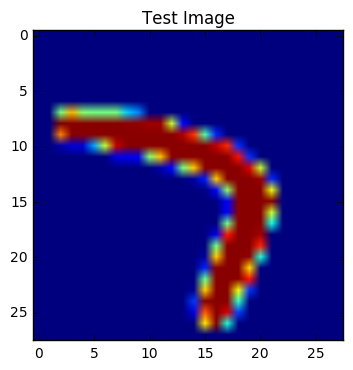

In [25]:
test_image_index = np.random.randint(0, len(X_test) - 1)
test_image = X_test[test_image_index]
test_image = test_image.reshape(test_image.shape[0], test_image.shape[1])

# Plot image
imshow = plt.imshow
plt.title("Test Image")
imshow(test_image)

### Save Model Filters

In [26]:
def save_model_filters(model, model_name, epoch_name):
    
    # Get the USER selected model architecture
    USER_model_arch = MODEL_DATA[model_name]["user_arch"]
    
    # Get count of conv layers from model arch
    conv_layer_num = USER_model_arch.count("conv_relu")

    # Generate conv layer names for accessing layers of TensorFlow model
    conv_layer_names = ["conv_{}".format(i) for i in range(conv_layer_num)]

    # Set conv layers dict
    MODEL_DATA[model_name]["epochs"][epoch_name]["conv_layers"] = {}

    
    # Iterate through conv names, accessing each conv layer
    for conv_name in conv_layer_names:
        
        # Set conv layer dict
        MODEL_DATA[model_name]["epochs"][epoch_name]["conv_layers"][conv_name] = {}
        
        
        # Generate model for conv layer
        conv_layer_model = Model(inputs=model.input,
                                  outputs=model.get_layer(conv_name).output)

        # Predict
        conv_layer_out = conv_layer_model.predict(X_test)

        # Find convolution layer depth 
        conv_depth = conv_depth_1 if conv_name == "conv_0" else conv_depth_2
        
        
        for test_image_index, test_image, label in test_images:
        
            # Set list of filters in current conv layer
            filters = [conv_layer_out[test_image_index,:,:,filt_id] for filt_id in range(conv_depth)]

            FILTER_DATA = []
            for filter_id, conv_filter in enumerate(filters):

                # Set filter name
                filter_name = "filter_{}".format(filter_id)

                # Set filter path
                FILTER_FILEPATH = "models/{}/{}/conv_layers/{}/{}_label{}.jpg".format(model_name, epoch_name, conv_name, filter_name, label)

                # Determine color mapping of image save
                save_filter = cmap(conv_filter) if CMAP_ON else conv_filter

                # Write image to file
                scipy.misc.toimage(save_filter).save(FILTER_FILEPATH)

                # Set filter filepath
                MODEL_DATA[model_name]["epochs"][epoch_name]["conv_layers"][conv_name][filter_name] = {"filepath" : FILTER_FILEPATH}

            

### Fit all models

In [27]:
MODEL_ACCURACY_DATA = {}

for model_name, model_obj in models.items():
    print("{}".format(model_name))
    print("========")
    
    # Initialize MODEL_ACCURACY_DATA dict
    MODEL_ACCURACY_DATA[model_name] = {}
    
    # Set current model
    current_model = model_obj["model"]
    
    # Set epochs list into MODEL DATA and model accuracy data
    MODEL_DATA[model_name]["epochs"] = {}
    MODEL_ACCURACY_DATA[model_name]["epochs"] = {}
    
    for epoch_num in range(total_training_epochs):
        print("\tTraining Epoch {}".format(epoch_num))
        print("\t-----------------")
        
        # Set epoch name
        epoch_name = "epoch_{}".format(epoch_num)
        
        # Append new epoch num to MODEL DATA and MODEL_ACCURACY_DATA
        MODEL_DATA[model_name]["epochs"][epoch_name] = {"scores" : None, "conv_layers" : {}}
        MODEL_ACCURACY_DATA[model_name]["epochs"][epoch_name] = {"scores" : None}
        
        # Set callbacks
        callbacks = set_callbacks(model_name, epoch_name) if SAVE_EPOCH_WEIGHTS else []
        
        # Fit model
        current_model.fit(X_train, Y_train,                
                          batch_size=batch_size, epochs=1,
                          callbacks=callbacks,
                          verbose=1, validation_split=fit_validation_split)
        
        
        # Evaluate model
        evaluate_model(current_model, model_name, epoch_name)
        
        # Save model filters
        if SAVE_ALL_FILTERS:
            save_model_filters(current_model, model_name, epoch_name)
        
        
        print("\n")
    print("\n")

model_0
	Training Epoch 0
	-----------------
Train on 11999 samples, validate on 48001 samples
Epoch 1/1
 9856/10000 [============================>.] - ETA: 0s

	Training Epoch 1
	-----------------
Train on 11999 samples, validate on 48001 samples
Epoch 1/1
10000/10000 [==============================] - 2s     




model_1
	Training Epoch 0
	-----------------
Train on 11999 samples, validate on 48001 samples
Epoch 1/1
10000/10000 [==============================] - 2s     


	Training Epoch 1
	-----------------
Train on 11999 samples, validate on 48001 samples
Epoch 1/1
 9952/10000 [============================>.] - ETA: 0s





# Evaluate Models

In [28]:
for model_obj in models.values():
    loss, accr = model_obj["model"].evaluate(X_test, Y_test, verbose=1)  # Evaluate the trained model on the test set!`b

 9920/10000 [============================>.] - ETA: 0s

## Save Models

In [29]:
models["model_0"]["arch"]
models["model_0"].keys()

dict_keys(['model', 'arch', 'kernel'])

In [41]:
for model_name, model_obj in models.items():
    
    
    
    # Set current model
    current_model = model_obj["model"]
    
    with open("../models/test.json", "w") as model_scores_file:
        json.dump(MODEL_ACCURACY_DATA[model_name]["epochs"], model_scores_file)
    
    # Convert to JSON
    model_json = current_model.to_json()
    
    with open("../models/model.json".format(model_name), "w") as json_file:
        json_file.write(model_json)
        
    # serialize weights to HDF5
    current_model.save_weights("../models/model.h5".format(model_name))
    print("Saved model to disk")
    


Saved model to disk
Saved model to disk


In [31]:
# for model_name, model_obj in models.items():
    
#     # Set current model
#     current_model = model_obj["model"]
    
#     with open("models/final_models/{0}/{0}_scores.json".format(model_name), "w") as model_scores_file:
#         json.dump(MODEL_ACCURACY_DATA[model_name]["epochs"], model_scores_file)
    
#     # Convert to JSON
#     model_json = current_model.to_json()
    
#     with open("models/final_models/{0}/{0}_arch.json".format(model_name), "w") as json_file:
#         json_file.write(model_json)
        
#     # serialize weights to HDF5
#     current_model.save_weights("models/final_models/{0}/{0}_weights.h5".format(model_name))
#     print("Saved model to disk")
    


# Hidden Layer Visualization

In [32]:
layer_name = "conv_0"

model = models["model_0"]["model"]

new_model = Model(inputs=model.input,
                  outputs=model.get_layer(layer_name).output)

In [33]:
new_model_out = new_model.predict(X_test)

# Save Conv Filters

### Set Test Image for Filters

In [34]:
test_image_index = np.random.randint(0, len(X_test) - 1)
test_image = X_test[test_image_index]
test_image = test_image.reshape(test_image.shape[0], test_image.shape[1])

### Plot filter images function

In [35]:
def display_filters(conv_depth, filters):
    fig = plt.figure()

    for i in range(conv_depth):
        filter_num = i+1
        ax = plt.subplot(conv_depth//4+1, 4, filter_num)

        imshow = plt.imshow #alias
        imshow(filters[i])

        ax.set_title("Filter: {}".format(filter_num))
        ax.set_xticks([])
        ax.set_yticks([])

    fig.set_figwidth(20)
    fig.set_figheight(20)

# Write Model Data

### Save Model Data to JSON

In [36]:
for model_num, model_obj in enumerate(models.values()):
    MODEL_ARCH_FILEPATH = 'models/model_{0}/model_{0}.json'.format(model_num)
    
    with open(MODEL_ARCH_FILEPATH, 'w') as fp:
        json.dump(MODEL_DATA, fp)    

<hr>


<hr>


<hr>


<hr>


<hr>


# Plot Test Image

In [37]:
test_image_index = np.random.randint(0, len(X_test) - 1)
test_image = X_test[test_image_index]
test_image = test_image.reshape(test_image.shape[0], test_image.shape[1])

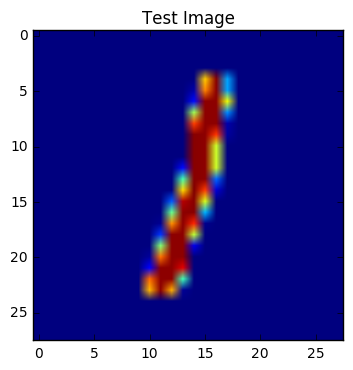

In [38]:
imshow = plt.imshow #alias
plt.title("Test Image")
imshow(test_image)

# Setup Hidden Layer Filters

In [39]:
conv_depth = conv_depth_1 if (layer_name == "conv_0" or layer_name == "conv_1") else conv_depth_2
filters = [new_model_out[test_image_index,:,:,filt_id] for filt_id in range(conv_depth)]

# Show Filters

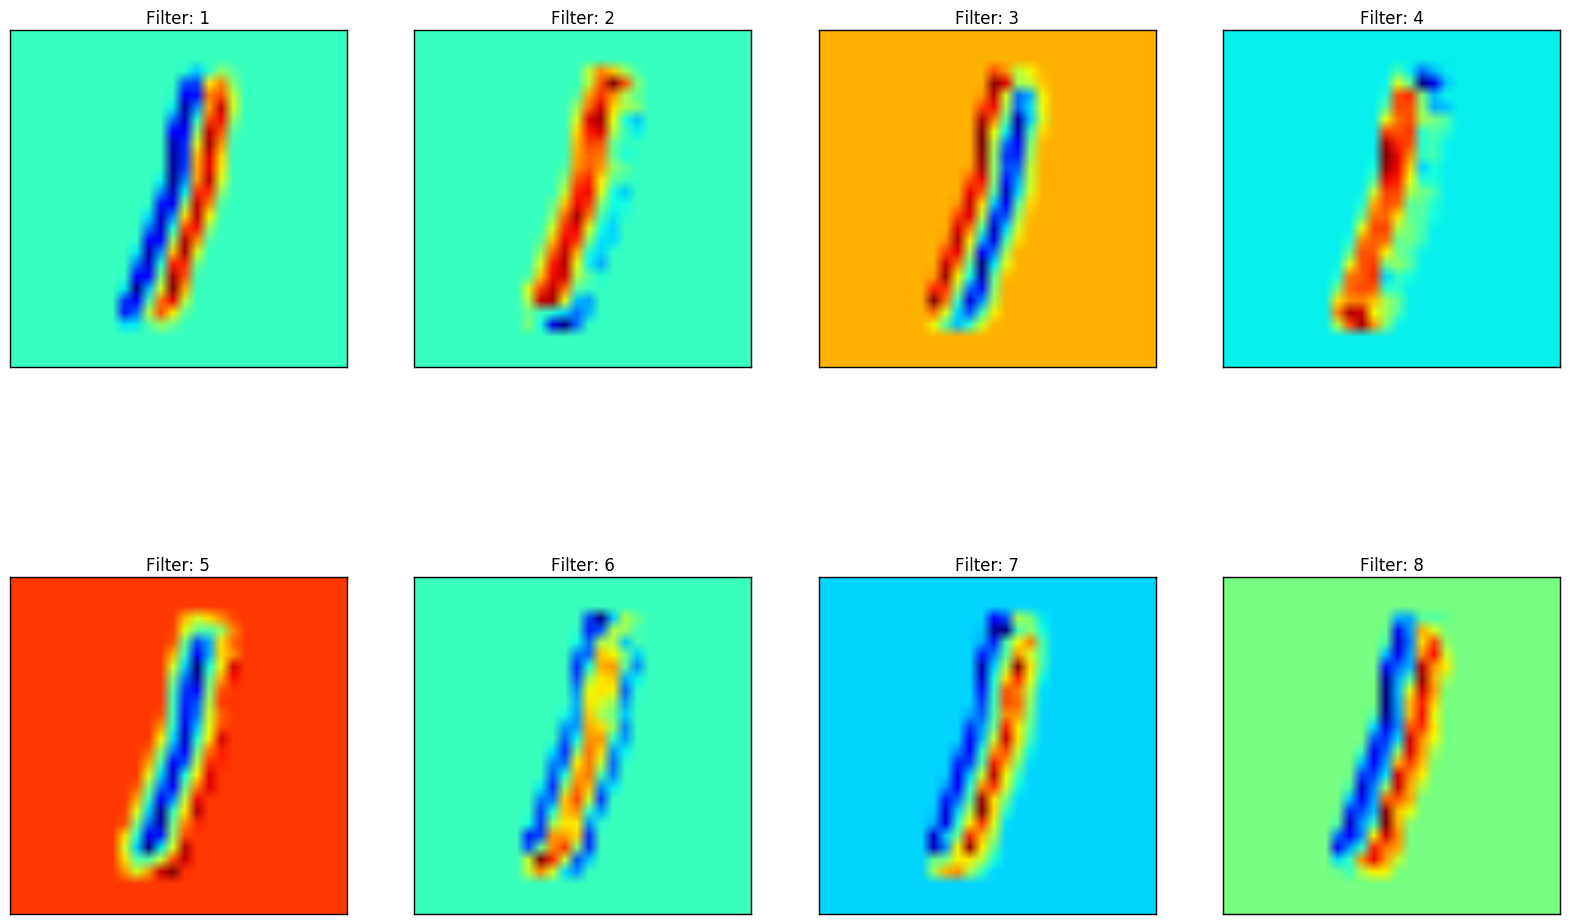

In [40]:
fig = plt.figure()

for i in range(conv_depth):
    filter_num = i+1
    ax = plt.subplot(conv_depth//4+1, 4, filter_num)
    
    imshow = plt.imshow #alias
    imshow(filters[i])
#     imshow(filters[i], cmap=plt.get_cmap('gray'))
    
    ax.set_title("Filter: {}".format(filter_num))
    ax.set_xticks([])
    ax.set_yticks([])
    
fig.set_figwidth(20)
fig.set_figheight(20)

<hr>


<hr>


<hr>


<hr>


# References

https://keras.io/getting-started/faq/#how-can-i-obtain-the-output-of-an-intermediate-layer




https://github.com/fchollet/keras/issues/431

http://stackoverflow.com/questions/36745821/keras-1-0-getting-intermediate-layer-output/36789699#36789699

https://github.com/fchollet/keras/issues/2417

http://stackoverflow.com/questions/41911883/typeerror-tensor-object-is-not-callable